In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm

In [15]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

value_to_predict = 'Sex'
# value_to_predict = 'population'
value_to_predict = 'Age'

In [16]:

fname = next((fdir_external / "HEART" / 'reg').glob("*processed.h5"))
fname = fname.name

data = pd.read_hdf(fdir_external / "HEART" / 'reg' / fname, index_col=0)
data_header = pd.read_csv(fdir_external / "HEART" / 'reg' / 'SraRunTable.txt', sep=',')
data_header.set_index('Run', inplace=True)

In [17]:
# y = data_header[value_to_predict]
# X = data.values

sex = 'male'
sex = 'female'
y = data_header.loc[data_header['sex'] == sex][value_to_predict]
X = data.loc[data_header['sex'] == sex].values

X = RobustScaler().fit_transform(X)
# X = StandardScaler().fit_transform(X)

In [18]:
from scipy.stats import spearmanr

rhos = []
pvalues = []

for i in tqdm(range(X.shape[1])):
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)


100%|██████████| 102378/102378 [01:02<00:00, 1647.60it/s]


In [19]:
# np.argwhere(np.array(pvalues) < 0.05).shape
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)
# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0


In [20]:
corr_threshold = 0.95
# rhos = np.array(rhos)
sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
# np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'MSTRG.15680.3'),
  Text(1, 0, 'ENST00000339468.8'),
  Text(2, 0, 'MSTRG.23984.6'),
  Text(3, 0, 'ENST00000608052.1'),
  Text(4, 0, 'MSTRG.25597.20'),
  Text(5, 0, 'MSTRG.30862.1'),
  Text(6, 0, 'MSTRG.21843.8'),
  Text(7, 0, 'MSTRG.17896.2'),
  Text(8, 0, 'MSTRG.21086.53'),
  Text(9, 0, 'MSTRG.8980.3'),
  Text(10, 0, 'ENST00000519214.5'),
  Text(11, 0, 'MSTRG.28762.4'),
  Text(12, 0, 'ENST00000527612.1'),
  Text(13, 0, 'ENST00000690968.2')])

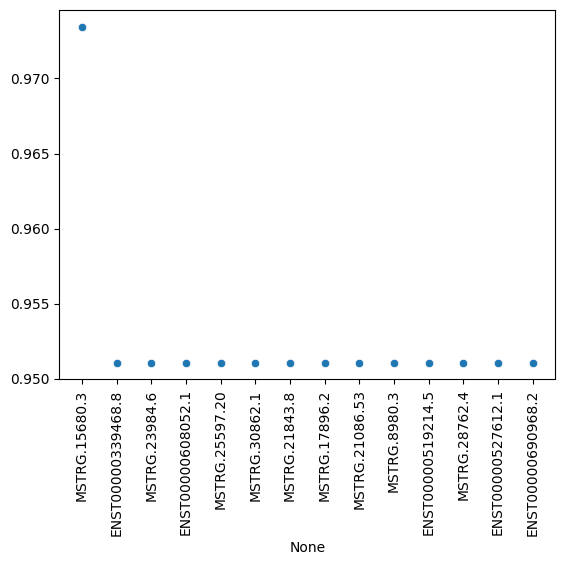

In [21]:
# plt.figure(figsize=(16,6))
sns.scatterplot(
    y=np.abs(rhos[sorted_corr_ids]), 
    x=data.columns[sorted_corr_ids],
    )
plt.xticks(rotation=90)

In [22]:
data.columns[sorted_corr_ids]

Index(['MSTRG.15680.3', 'ENST00000339468.8', 'MSTRG.23984.6',
       'ENST00000608052.1', 'MSTRG.25597.20', 'MSTRG.30862.1', 'MSTRG.21843.8',
       'MSTRG.17896.2', 'MSTRG.21086.53', 'MSTRG.8980.3', 'ENST00000519214.5',
       'MSTRG.28762.4', 'ENST00000527612.1', 'ENST00000690968.2'],
      dtype='object')

In [23]:
spearmanr(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]])

SignificanceResult(statistic=-0.9490938946064404, pvalue=8.239847058692726e-06)

In [24]:
spearmanr(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], y)

SignificanceResult(statistic=-0.9510759457296009, pvalue=6.9113295015950775e-06)

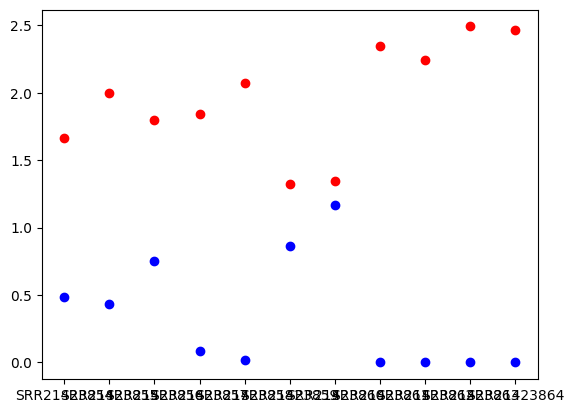

In [25]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [26]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]]

SRR21423854    1.666952
SRR21423855    1.997066
SRR21423856    1.796135
SRR21423857    1.841829
SRR21423858    2.070627
SRR21423859    1.322645
SRR21423860    1.343691
SRR21423861    2.349392
SRR21423862    2.247180
SRR21423863    2.492263
SRR21423864    2.468072
Name: ENST00000339468.8, dtype: float32